In [1]:
import os
print(os.path.abspath("./"))
print(os.path.abspath("../"))

import sys
sys.path.append("../")

c:\Users\Hasan\Work\akrule\notebooks
c:\Users\Hasan\Work\akrule


In [2]:
from akrule.time_series import AKRuleBasedTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

# Data Prepration

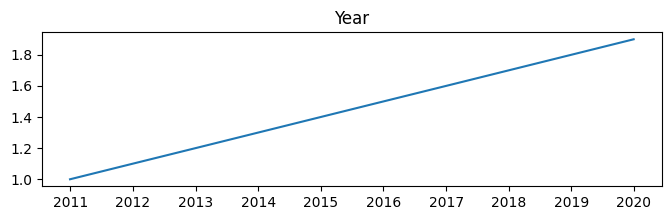

In [3]:
N = 10
data_year = np.ones(N)
trend = np.arange(0,N) / N
data_year += trend
df_year = pd.DataFrame()
df_year["y"] = data_year
df_year.index = pd.date_range(start='1/1/2010', end='1/1/2020', freq="1Y")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_year.index, df_year.y)
ax.set_title("Year");

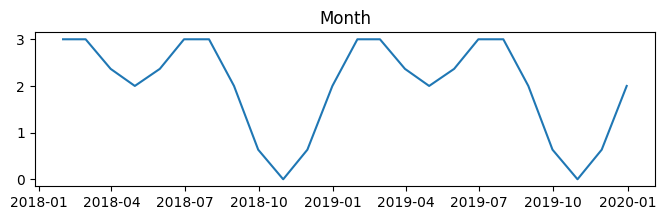

In [4]:
N = 24
x = np.arange(0,N)
y =  np.sin(4*np.pi*x/N)+np.cos(8*np.pi*x/N)+2
df_month = pd.DataFrame()
df_month["y"] = y
df_month.index = pd.date_range(start='1/1/2018', end='1/1/2020', freq="1M")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_month.index, df_month.y)
ax.set_title("Month");

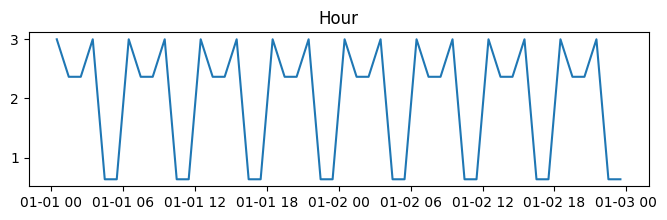

In [5]:
N = 48
x = np.arange(0,N)
y =  np.sin(16*np.pi*x/N)+np.cos(32*np.pi*x/N)+2
df_hour = pd.DataFrame()
df_hour["y"] = y
df_hour.index = pd.date_range(start='1/1/2020 00:30:00', end='1/3/2020', freq="1H")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_hour.index, df_hour.y)
ax.set_title("Hour");

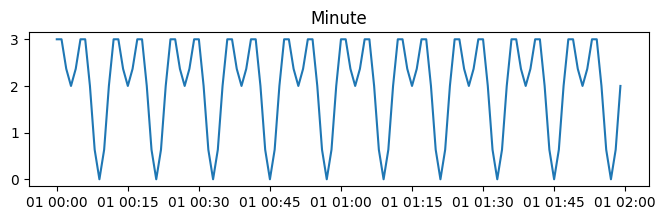

In [6]:
N = 120
x = np.arange(0,N)
y =  np.sin(20*np.pi*x/N)+np.cos(40*np.pi*x/N)+2
df_minute = pd.DataFrame()
df_minute["y"] = y
df_minute.index = pd.date_range(start='1/1/2020 00:00:01', end='1/1/2020 02:00:00', freq="1T")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_minute.index, df_minute.y)
ax.set_title("Minute");

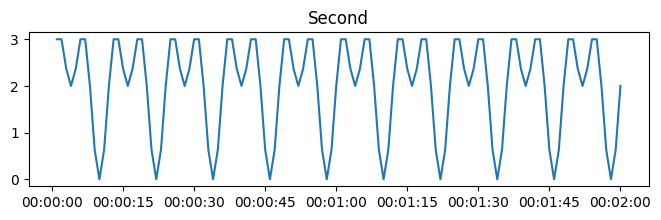

In [7]:
N = 120
x = np.arange(0,N)
y =  np.sin(20*np.pi*x/N)+np.cos(40*np.pi*x/N)+2
df_second = pd.DataFrame()
df_second["y"] = y
df_second.index = pd.date_range(start='1/1/2020 00:00:01', end='1/1/2020 00:02:00', freq="1S")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_second.index, df_second.y)
ax.set_title("Second");

# Test

In [58]:
import warnings
from sklearn.metrics import r2_score


def QAPE_Percentage_Bootstrap_Score(y_true, y_pred, num_samples=1000, ci=0.95):
    """
    """
    error = np.abs(np.subtract(y_true, y_pred)) / np.maximum(np.abs(y_true), np.finfo(np.float64).eps)
    
    idx = np.random.randint(0, error.shape[0], size=(num_samples, error.shape[0]))
    resamples_error = error[idx]
    
    quantile_error = np.quantile(resamples_error, ci, axis=1)
    return quantile_error.mean()

def QAPE_Amount_Bootstrap_Score(y_true, y_pred, num_samples=1000, ci=0.95):
    """
    """
    error = np.abs(np.subtract(y_true, y_pred))
    
    idx = np.random.randint(0, error.shape[0], size=(num_samples, error.shape[0]))
    resamples_error = error[idx]
    
    quantile_error = np.quantile(resamples_error, ci, axis=1)
    return quantile_error.mean()

def QAPE_Mix_Score(group, num_samples=1000, ci=0.95):
    """
    """
    y_true = group.y.values
    y_pred = group.y_pred.values
    error_per = np.abs(np.subtract(y_true, y_pred)) / np.maximum(np.abs(y_true), np.finfo(np.float64).eps)
    error_amo = np.abs(np.subtract(y_true, y_pred))
    
    idx = np.random.randint(0, error_per.shape[0], size=(num_samples, error_per.shape[0]))
    resamples_error_per = error_per[idx]
    resamples_error_amo = error_amo[idx]
    
    quantile_error_per = np.quantile(resamples_error_per, ci, axis=1)
    quantile_error_amo = np.quantile(resamples_error_amo, ci, axis=1)
    
    group["ScoreQAPE_PER"] = quantile_error_per.mean()
    group["ScoreQAPE_AMO"] = quantile_error_amo.mean()
    group["ScoreR2"] = r2_score(y_true[np.isfinite(y_true)], y_pred[np.isfinite(y_pred)])
    return group
    
        
class AKRuleBasedTS():
    """
    """
    
    def __init__(self, freqs: list=[], tag_features: list=[], average_num: int=3, trend_level: int=0, holidays: bool=False, fillna: bool=True, inplace: bool=False, 
                 metric_num_samples=1000, metric_ci=0.95):
        self.freqs = freqs
        self.tag_features = tag_features
        self.average_num = average_num
        self.trend_level = trend_level
        self.trend_x = None
        self.trend_dict = {}
        self.holidays = holidays
        self.fillna = fillna
        self.inplace = inplace
        self.metric_num_samples = metric_num_samples
        self.metric_ci = metric_ci
        self.df_rule = None
        
        if not isinstance(self.freqs, list): raise TypeError("freqs must be list format!")
        if not isinstance(self.tag_features, list): raise TypeError("tag_features must be list format!")
        if not isinstance(self.average_num, int): raise TypeError("average_num must be int format!")
        if not isinstance(self.trend_level, int): raise TypeError("trend_level must be int format!")
        if not isinstance(self.holidays, bool): raise TypeError("holidays must be bool format!")
        if not isinstance(self.fillna, bool): raise TypeError("fillna must be bool format!")
        if not isinstance(self.inplace, bool): raise TypeError("inplace must be bool format!")
        if not isinstance(self.metric_num_samples, int): raise TypeError("metric_num_samples must be int format!")
        if not isinstance(self.metric_ci, float): raise TypeError("metric_ci must be float format!")
        
        for index, freq in enumerate(self.freqs):
            self.freqs[index] = freq.upper()
        
        self.freqs_order = ["YEARLY", "MONTHLY", "WEEKLY", "DAYOFYEAR", "DAYOFMONTH", "DAYOFWEEK", "HOURLY", "MINUTELY"]
        self.freq_order = None
        for freq_order in self.freqs_order:
            if freq_order.upper() in self.freqs:
                self.freq_order = freq_order
        if self.freq_order is None and fillna:
            self.fillna = False
            warnings.warn(f"Warning... There should be frequency like {self.freqs_order}!")
    
    def _check_data(self, X: pd.DataFrame):
        if not "time" in X.columns:
            raise KeyError("There is no time feature in DataFrame!")
        if not "y" in X.columns:
            raise KeyError("There is no y feature in DataFrame!")
        if not isinstance(X.time.values[0], np.datetime64):
            raise TypeError("time is not np.datetime64 format!")
        if not isinstance(X.y.values[0], (int, float)):
            raise TypeError("y is not numeric format!")
        for tag in self.tag_features:
            if not tag in X.columns:
                raise KeyError(f"There is no {tag} feature in DataFrame!")
        if len(self.tag_features) == 0:
            self.tag_features = ["TEMP"]
            X["TEMP"] = True
        return X
    
    def _fillna(self, X: pd.DataFrame):
        def __fillna_group(group):
            group.infer_objects(copy=False).interpolate(method='linear', inplace=True)
            group.ffill(inplace=True)
            group.bfill(inplace=True)
            return group
        
        if self.freq_order == "YEARLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1Y")
        elif self.freq_order == "MONTHLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1M")
        elif self.freq_order == "WEEKLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1W")
        elif self.freq_order == "DAYOFYEAR":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1D")
        elif self.freq_order == "DAYOFMONTH":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1D")
        elif self.freq_order == "DAYOFWEEK":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1D")
        elif self.freq_order == "HOURLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1H")
        elif self.freq_order == "MINUTELY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1T")
        
        df_time = pd.DataFrame(time_index, columns=["time"])
        X_tags = X[self.tag_features].drop_duplicates()
        df_time = df_time.merge(X_tags, how="cross")

        X = X.merge(df_time, on=["time"]+self.tag_features, how="right")        
        X["isna"] = X.y.isna()
        X = X.groupby(self.tag_features, as_index=False).apply(lambda group: __fillna_group(group))
        X.reset_index(drop=True, inplace=True)
        return X
    
    def _set_trend(self, X: pd.DataFrame):
        trend_cols = [f"res_polyfit{i}" for i in range(self.trend_level+1)]
        tag = self.tag_features[0]
        value = X[tag].unique()[0]
        self.trend_x = np.arange(X[X[tag]==value].shape[0])
        res = X.groupby(self.tag_features).apply(lambda x: pd.Series(np.polyfit(self.trend_x, x.y, self.trend_level), 
                                                                                    index=trend_cols))
            
        time_values = X["time"].unique()
        if len(time_values) != self.trend_x.shape[0]: raise ValueError("Unique time shape does not match y values shape!")
        trend_preds = []
        for index, row in res.iterrows():
            self.trend_dict[index] = np.poly1d(row.values)
            trend_pred = pd.DataFrame()
            trend_pred["time"] = time_values
            trend_pred["y_trend"] = self.trend_dict[index](self.trend_x)
            trend_pred[self.tag_features] = index
            trend_preds.append(trend_pred)
        trend_preds = pd.concat(trend_preds) if len(trend_preds)>1 else trend_preds[0]
        
        X = X.merge(trend_preds, on=["time"]+self.tag_features, how="left")
        X["y_notrend"] = X["y"] - X["y_trend"]
        return X
    
    def _set_freqs(self, X: pd.DataFrame):
        for freq in self.freqs:
            if freq.upper() == "YEARLY":
                X["YEARLY"] = X.time.dt.year
            elif freq.upper() == "DAYOFYEAR":
                X["DAYOFYEAR"] = X.time.dt.dayofyear
            elif freq.upper() == "MONTHLY":
                X["MONTHLY"] = X.time.dt.month
            elif freq.upper() == "DAYOFMONTH":
                X["DAYOFMONTH"] = X.time.dt.daysinmonth
            elif freq.upper() == "WEEKLY":
                X["DAYOFMONTH"] = (X.time.dt.dayofyear / 7).astype(int)
            elif freq.upper() == "DAYOFWEEK":
                X["DAYOFWEEK"] = X.time.dt.dayofweek
            elif freq.upper() == "HOURLY":
                X["HOURLY"] = X.time.dt.hour
            elif freq.upper() == "MINUTELY":
                X["MINUTELY"] = X.time.dt.minute
    
    def _get_median_preds(self, X: pd.DataFrame):        
        X_size = X.groupby(self.freqs, as_index=False).size()
        X_size["pred_index"] = np.arange(X_size.shape[0])
        X_size.drop(["size"], axis=1, inplace=True)
        X = X.merge(X_size, on=self.freqs, how="left")
        
        X_group = X.groupby(self.freqs[1:]+self.tag_features).rolling(self.average_num).agg({
            "y_notrend":"median",
            "pred_index":"max"
        })
        
        X_group.reset_index(inplace=True)
        X_group["pred_index"] += 1
        X_group.rename(columns={"y_notrend":"y_notrend_pred"}, inplace=True)
        
        self.df_rule = X_group.loc[X_group["pred_index"]==X_group["pred_index"].max(), 
                                   self.freqs[1:]+self.tag_features+["y_notrend_pred"]]
        X = X.merge(X_group[self.freqs[1:]+self.tag_features+["y_notrend_pred", "pred_index"]], on=self.freqs[1:]+self.tag_features+["pred_index"], how="left")
        return X
    
    def _get_scores(self, X: pd.DataFrame):
        scores = X.groupby(self.tag_features, as_index=False).apply(lambda group: pd.Series(
            {
                'ScoreQAPE_PER': QAPE_Percentage_Bootstrap_Score(group['y_notrend'].values, group['y_notrend_pred'].values, num_samples=self.metric_num_samples, ci=self.metric_ci),
                'ScoreQAPE_AMO': QAPE_Amount_Bootstrap_Score(group['y_notrend'].values, group['y_notrend_pred'].values, num_samples=self.metric_num_samples, ci=self.metric_ci),
                'ScoreR2': r2_score(group['y_notrend'].values, group['y_notrend_pred'].values)
            }
        ))
        return scores
    
    def fit_predict(self, X_ori: pd.DataFrame):
        X = X_ori if self.inplace else X_ori.copy()
        X = self._check_data(X)        
        X = self._fillna(X) if self.fillna else X.assign(isna=X.y.isna())
        X = self._set_trend(X) if self.trend_level>0 else X.assign(y_notrend=X.y)
        self._set_freqs(X)
        display(X)
        X = self._get_median_preds(X)
        display(X)
        display(self.df_rule)
        X_clear = X[self.tag_features+["y_notrend", "y_notrend_pred"]].dropna()
        scores = self._get_scores(X_clear)
        display(scores)
        
        """
        # Rolling
        best_score, best_roll = 999, -1
        for index, minute_round in enumerate(self.minute_round):
            X_tr["y_pred_roll"] = X_tr.y_pred.rolling(minute_round,center=True).median()
            y_true = X_tr.y
            y_pred = X_tr.y_pred_roll
            roll_score = QAPE_75(y_true,y_pred)
        """        
        
        """
        # Holiday Prediction
        """
        
        """
        # Prediction Calibration
        """
        
        return X
    

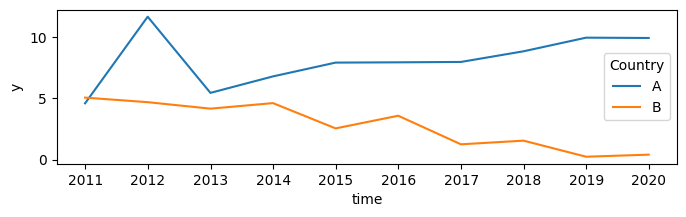

In [9]:
from akrule.time_series import get_yearly_data

df_year = get_yearly_data(N=10, max_value=10, noise_std=0.5, anomaly_percentage=10)

fig, ax = plt.subplots(figsize=(8,2))
sns.lineplot(data=df_year, x="time", y="y", hue="Country", ax=ax);

In [61]:
df_year_temp = df_year.copy()
#df_year_temp["time"] = df_year_temp["time"].astype(str)
#df_year_temp.loc[df_year_temp["time"]=="2011-12-31", "y"] = np.nan
df_year_temp = df_year_temp.loc[df_year_temp["time"]!="2011-12-31", :].copy()
df_year_temp = df_year_temp.loc[~((df_year_temp["time"]=="2019-12-31")&(df_year_temp["Country"]=="A")), :].copy()
df_year_temp = df_year_temp.loc[~((df_year_temp["time"]=="2010-12-31")&(df_year_temp["Country"]=="B")), :].copy()

model = AKRuleBasedTS(freqs=["yearly"], tag_features=["Country"], average_num=3, trend_level=1, fillna=True, inplace=False)
X = model.fit_predict(df_year_temp)

C:\Users\Hasan\AppData\Local\Temp\ipykernel_8396\1671824621.py:108: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  group.infer_objects(copy=False).interpolate(method='linear', inplace=True)
C:\Users\Hasan\AppData\Local\Temp\ipykernel_8396\1671824621.py:108: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  group.infer_objects(copy=False).interpolate(method='linear', inplace=True)


,time,y,Country,Anomaly,isna,y_trend,y_notrend,YEARLY
0,2010-12-31,4.583828,A,1.0,False,4.615582,-0.031753,2010
1,2011-12-31,5.009445,A,1.0,True,5.240379,-0.230933,2011
2,2012-12-31,5.435062,A,1.0,False,5.865176,-0.430113,2012
3,2013-12-31,6.777563,A,1.0,False,6.489973,0.287590,2013
4,2014-12-31,7.900735,A,1.0,False,7.114770,0.785964,2014
5,2015-12-31,7.923062,A,1.0,False,7.739567,0.183495,2015
6,2016-12-31,7.954278,A,1.0,False,8.364364,-0.410086,2016
7,2017-12-31,8.822254,A,1.0,False,8.989162,-0.166908,2017
8,2018-12-31,9.932730,A,1.0,False,9.613959,0.318771,2018
9,2019-12-31,9.932730,A,1.0,True,10.238756,-0.306026,2019


,time,y,Country,Anomaly,isna,y_trend,y_notrend,YEARLY,pred_index,y_notrend_pred
0,2010-12-31,4.583828,A,1.0,False,4.615582,-0.031753,2010,0,NaN
1,2011-12-31,5.009445,A,1.0,True,5.240379,-0.230933,2011,1,NaN
2,2012-12-31,5.435062,A,1.0,False,5.865176,-0.430113,2012,2,NaN
3,2013-12-31,6.777563,A,1.0,False,6.489973,0.287590,2013,3,-0.230933
4,2014-12-31,7.900735,A,1.0,False,7.114770,0.785964,2014,4,-0.230933
5,2015-12-31,7.923062,A,1.0,False,7.739567,0.183495,2015,5,0.287590
6,2016-12-31,7.954278,A,1.0,False,8.364364,-0.410086,2016,6,0.287590
7,2017-12-31,8.822254,A,1.0,False,8.989162,-0.166908,2017,7,0.183495
8,2018-12-31,9.932730,A,1.0,False,9.613959,0.318771,2018,8,-0.166908
9,2019-12-31,9.932730,A,1.0,True,10.238756,-0.306026,2019,9,-0.166908


,Country,y_notrend_pred
9,A,-0.166908
19,B,0.013353


,Country,ScoreQAPE_PER,ScoreQAPE_AMO,ScoreR2
0,A,1.932155,0.838160,-1.061373
1,B,28.243016,1.555083,-1.180010


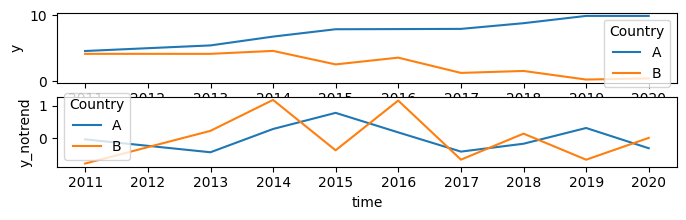

In [11]:
fig, axes = plt.subplots(2, figsize=(8,2))
sns.lineplot(data=X, x="time", y="y", hue="Country", ax=axes[0]);
sns.lineplot(data=X, x="time", y="y_notrend", hue="Country", ax=axes[1]);